# Predicting the Sale Price of Bulldozers using Machine Learning

This notebook uses various Python-based machine learning and data scince libraris in an attempt to build a machine learning model capable of predicting the sale price of bulldozers.

## 1. Problem Definition

Given the characteristics of a bulldozer with previous examples of how much similar bulldozers have been sold for, how can the sale price be predicted of the given bulldozer?

## 2. Data

The data is downloaded from the Kaggle Bluebook for Bulldozers competition:
https://www.kaggle.com/competitions/bluebook-for-bulldozers/data

There are 3 main datasets:

- Train.csv is the training set, which contains data through the end of 2011.
- Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012.
- Test.csv is the test set, it contains data from May 1, 2012 - November 2012.

## 3. Evaluation

The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.
www.kaggle.com/competitions/bluebook-for-bulldozers/overview/evaluation

## 4. Features

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
dirpath = "drive/MyDrive/bulldozer_price_predictor/bluebook-for-bulldozers/"
features_dictionary = pd.read_excel(dirpath + "Data Dictionary.xlsx", index_col = 0, engine = "openpyxl")
features_dictionary.style.set_table_styles({'Description': [{'selector': '',
           'props': [('width', '1000px')]}]})
features_dictionary.style.set_properties(**{'text-align': 'left'})

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,Description
Variable,
SalesID,unique identifier of a particular sale of a machine at auction
MachineID,identifier for a particular machine; machines may have multiple sales
ModelID,identifier for a unique machine model (i.e. fiModelDesc)
datasource,source of the sale record; some sources are more diligent about reporting attributes of the machine than others. Note that a particular datasource may report on multiple auctioneerIDs.
auctioneerID,"identifier of a particular auctioneer, i.e. company that sold the machine at auction. Not the same as datasource."
YearMade,year of manufacturer of the Machine
MachineHoursCurrentMeter,current usage of the machine in hours at time of sale (saledate); null or 0 means no hours have been reported for that sale
UsageBand,"value (low, medium, high) calculated comparing this particular Machine-Sale hours to average usage for the fiBaseModel; e.g. 'Low' means this machine has less hours given it's lifespan relative to average of fiBaseModel."
Saledate,time of sale


## Importing Needed Tools

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import RandomizedSearchCV

## Exploring the data

In [ ]:
# Import training and validation sets
df = pd.read_csv(dirpath + "TrainAndValid.csv", low_memory = False)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [ ]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

<Axes: ylabel='Frequency'>

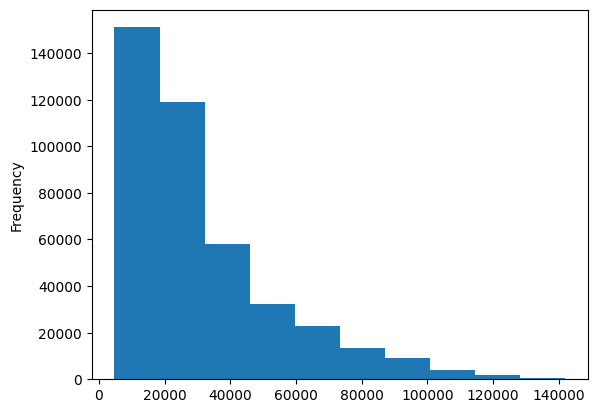

In [ ]:
df.SalePrice.plot.hist()

According to the figure above, most of the sale prices are under 20,000 USD.

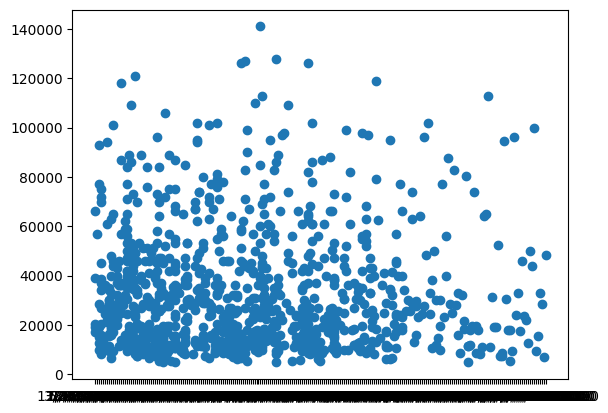

In [ ]:
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000])

In [ ]:
df.saledate

0         11/16/2006 0:00
1          3/26/2004 0:00
2          2/26/2004 0:00
3          5/19/2011 0:00
4          7/23/2009 0:00
               ...       
412693      3/7/2012 0:00
412694     1/28/2012 0:00
412695     1/28/2012 0:00
412696      3/7/2012 0:00
412697     1/28/2012 0:00
Name: saledate, Length: 412698, dtype: object

### Parsing Dates

The dates are not in the correct format in order to visualize the sale prices across a period of time.

Using the `parse_dates` parameter, the format of the dates can be encoded into the correct format.

In [ ]:
# Updating the `saledate` column
df = pd.read_csv(dirpath + "TrainAndValid.csv",
                 low_memory = False,
                 parse_dates = ["saledate"])


In [ ]:
df.saledate

0        2006-11-16
1        2004-03-26
2        2004-02-26
3        2011-05-19
4        2009-07-23
            ...    
412693   2012-03-07
412694   2012-01-28
412695   2012-01-28
412696   2012-03-07
412697   2012-01-28
Name: saledate, Length: 412698, dtype: datetime64[ns]

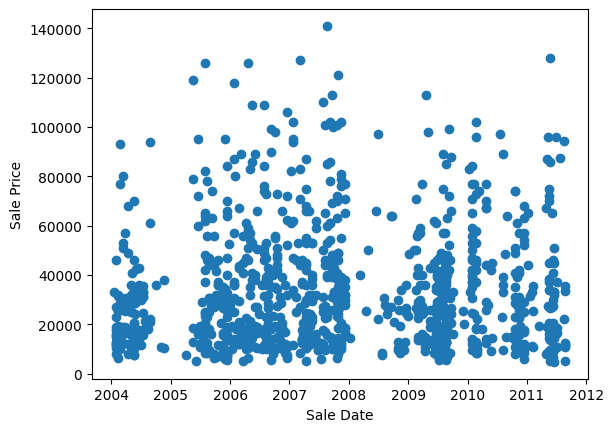

In [ ]:
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000])
ax.set_xlabel("Sale Date")
ax.set_ylabel("Sale Price")

plt.show()

According to the figure above, between the middle of 2004 to the middle of 2005 and from 2008 to the middle of 2009, the number of bulldozers sold decreased.

In [ ]:
df.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000.0,57000.0,10000.0,38500.0,11000.0
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3.0,3.0,3.0,3.0,3.0
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68.0,4640.0,2838.0,3486.0,722.0
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


### Sort the DataFrame by the Sale Date


In [ ]:
# Sort Dataframe in date order
df.sort_values(by = ["saledate"], inplace = True, ascending = True)
df.saledate.head(10)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
Name: saledate, dtype: datetime64[ns]

In [ ]:
# Make a copy of the original dataframe
df_tmp = df.copy()
df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,1989-01-17,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,Lever,NaN,NaN


### Add datetime paramaters for `saledate` column

In [ ]:
df_tmp["saleYear"] = df_tmp.saledate.dt.year
df_tmp["saleMonth"] = df_tmp.saledate.dt.month
df_tmp["saleDay"] = df_tmp.saledate.dt.day
df_tmp["saleDayOfYear"] = df_tmp.saledate.dt.dayofyear
df_tmp["saleDayOfWeek"] = df_tmp.saledate.dt.dayofweek

In [ ]:
df_tmp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-17 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00


In [ ]:
df_tmp.drop("saledate", axis = 1, inplace = True)

In [ ]:
df_tmp.state.value_counts()

state
Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virgi

### Conver Strings to Categories

Turning the data into numbers by converting the strings into pandas categories.

In [ ]:
# Find the columns that contain strings
for column, content in df_tmp.items():
  if pd.api.types.is_string_dtype(content):
    df_tmp[column] = content.astype("category").cat.as_ordered()


In [ ]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   object  
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  object  
 12  fiModelSeries             58667 non-null   object  
 13  fiModelDescriptor         748

In [ ]:
df_tmp.state.cat.categories, df_tmp.state.cat.codes.unique()

(Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
        'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
        'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
        'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
        'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
        'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
        'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
        'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
        'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
        'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
        'Wyoming'],
       dtype='object'),
 array([43,  8,  9, 40, 35, 37,  2, 48, 27, 29,  5,  4, 13, 19, 45, 30, 52,
        31, 12, 24,  6, 16, 17, 42, 22, 25, 33, 36, 15,  0, 18, 34, 47,  7,
        28, 23, 14, 51, 32, 46,  1, 11, 26,  3, 39, 41, 44, 38, 50

### Save Preprocessed Data

In [ ]:
# Export the copied dataframe to a new csv file
df_tmp.to_csv("drive/MyDrive/bulldozer_price_predictor/data/train_temp.csv", index = False)

In [ ]:
# Import preprocessed data
df_tmp = pd.read_csv("drive/MyDrive/bulldozer_price_predictor/data/train_temp.csv", low_memory = False)

In [ ]:
df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayOfYear,saleDayOfWeek
0,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,TD20,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,17,17,1
1,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,A66,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,31,1
2,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,D7G,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,31,31,1
3,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,A62,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,31,1
4,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,D3B,...,None or Unspecified,PAT,Lever,NaN,NaN,1989,1,31,31,1


In [ ]:
# Check the percentage of missing values per column
df_tmp.isna().sum() / len(df_tmp)

SalesID                     0.000000
SalePrice                   0.000000
MachineID                   0.000000
ModelID                     0.000000
datasource                  0.000000
auctioneerID                0.048791
YearMade                    0.000000
MachineHoursCurrentMeter    0.642586
UsageBand                   0.821492
fiModelDesc                 0.000000
fiBaseModel                 0.000000
fiSecondaryDesc             0.340993
fiModelSeries               0.857845
fiModelDescriptor           0.818715
ProductSize                 0.524851
fiProductClassDesc          0.000000
state                       0.000000
ProductGroup                0.000000
ProductGroupDesc            0.000000
Drive_System                0.740520
Enclosure                   0.000809
Forks                       0.520921
Pad_Type                    0.803498
Ride_Control                0.629928
Stick                       0.803498
Transmission                0.544444
Turbocharged                0.803498
B

In [ ]:
# Droping the rows with missing values
df_tmp.dropna(axis = 0)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayOfYear,saleDayOfWeek


It appears that every row has a missing value which means it has to be filled.

## Fill Missing Values

In [ ]:
# find the numeric columns that have missing values
for column, content in df_tmp.items():
  if pd.api.types.is_numeric_dtype(content):
    if pd.isnull(content).sum():
      print(column)

auctioneerID
MachineHoursCurrentMeter


Since there is 400,000+ examples, the missing values are better to be filled with the median than the mean since the mean is more sensetive to the variation of the data.

### Filling The Numertical Columns

In [ ]:
# Fill the numeric columns that have missing values
for column, content in df_tmp.items():
  if pd.api.types.is_numeric_dtype(content):
    if pd.isnull(content).sum():
      # Add a binary column which tells if the data was missing or not
      df_tmp[column + "_is_missing"] = pd.isnull(content)
      # Fill Missing numeric values with the median
      df_tmp[column] = content.fillna(content.median())

In [ ]:
df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayOfYear,saleDayOfWeek,auctioneerID_is_missing,MachineHoursCurrentMeter_is_missing
0,1646770,9500.0,1126363,8434,132,18.0,1974,0.0,NaN,TD20,...,None or Unspecified,NaN,NaN,1989,1,17,17,1,False,True
1,1821514,14000.0,1194089,10150,132,99.0,1980,0.0,NaN,A66,...,NaN,Standard,Conventional,1989,1,31,31,1,False,True
2,1505138,50000.0,1473654,4139,132,99.0,1978,0.0,NaN,D7G,...,None or Unspecified,NaN,NaN,1989,1,31,31,1,False,True
3,1671174,16000.0,1327630,8591,132,99.0,1980,0.0,NaN,A62,...,NaN,Standard,Conventional,1989,1,31,31,1,False,True
4,1329056,22000.0,1336053,4089,132,99.0,1984,0.0,NaN,D3B,...,Lever,NaN,NaN,1989,1,31,31,1,False,True


### Filling The Categorical Columns

In [ ]:
# find the categorical columns that have missing values
for column, content in df_tmp.items():
  if not pd.api.types.is_numeric_dtype(content):
      print(column)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [ ]:
# Fill the categorical columns that have missing values
for column, content in df_tmp.items():
  if not pd.api.types.is_numeric_dtype(content):
      # Add a binary column which tells if the data was missing or not
      df_tmp[column + "_is_missing"] = pd.isnull(content)
      # Turn categories into numbers and add +1
      df_tmp[column] = pd.Categorical(content).codes + 1

In [ ]:
df_tmp.head().T

,0,1,2,3,4
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
...,...,...,...,...,...
Backhoe_Mounting_is_missing,False,True,False,True,False
Blade_Type_is_missing,False,True,False,True,False
Travel_Controls_is_missing,False,True,False,True,False
Differential_Type_is_missing,True,False,True,False,True


In [ ]:
df_tmp.isna().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 103, dtype: int64

## Modelling

In [ ]:
# Finding the last year in the data
df_tmp.saleYear.unique().max()

2012

Since the model tries to find the price of a bulldozer based on previous examples, it makes sense to make the most recent examples in the validation set.

In [ ]:
# Split the data into training and validation sets
df_train = df_tmp[df_tmp.saleYear != 2012]
df_val = df_tmp[df_tmp.saleYear == 2012]

len(df_train), len(df_val)

(401125, 11573)

In [ ]:
# Split the data into X and y
X_train, y_train = df_train.drop("SalePrice", axis = 1), df_train["SalePrice"]
X_val, y_val = df_val.drop("SalePrice", axis = 1), df_val["SalePrice"]

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((401125, 102), (401125,), (11573, 102), (11573,))

### Building an Evaluation Function

In [ ]:
# Create evaluation function using RMSLE

def rmsle(y_test, y_pred):
  """
  Calculates root mean squared log error between predictions and true values.
  """
  return np.sqrt(mean_squared_log_error(y_test, y_pred))

# Create a function to evaluate model on few different levels
def show_scores(model):
  train_preds = model.predict(X_train)
  val_preds = model.predict(X_val)
  scores = {
    "Training RMSLE": rmsle(y_train, train_preds),
    "Validation RMSLE": rmsle(y_val, val_preds)
  }
  return scores

## Testing the Model on a Subset to Tune the hyperparameters

In [ ]:
# Creating a model
model = RandomForestRegressor(n_jobs = -1, random_state = 42, max_samples = 10000)

# Fit the model
model.fit(X_train, y_train)

RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

In [ ]:
show_scores(model)

{'Training RMSLE': 0.2577410303930966, 'Validation RMSLE': 0.2930925556053619}

### Hyperparameter tuning with RandomizedSearchCV

In [ ]:
# Different RandomForestRegressor hyperparameters
rf_grid = {
    "n_estimators": np.arange(10,100,10),
    "max_depth": [None, 3, 5, 10],
    "min_samples_split": np.arange(2, 20, 2),
    "max_features": [0.5, 1, "sqrt", "auto"],
    "max_samples": [10000],
}

# Instantiate RandomizedSearchCV model
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs = -1,
                                                    random_state = 42,
                                                    max_samples = 10000,),
                              param_distributions = rf_grid,
                              n_iter = 2,
                              cv = 5,
                              verbose = True,)



In [ ]:
# Fit the instantiated model
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(max_samples=10000, n_jobs=-1,
                                                   random_state=42),
                   n_iter=2,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [10000],
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [ ]:
# Find the best model hyperparameters
rs_model.best_params_

{'n_estimators': 40,
 'min_samples_split': 8,
 'max_samples': 10000,
 'max_features': 'sqrt',
 'max_depth': None}

In [ ]:
# Evaluate the model
show_scores(rs_model)

{'Training RMSLE': 0.31994893191048984,
 'Validation RMSLE': 0.36076272494679956}

In [ ]:
show_scores(model)

{'Training RMSLE': 0.2577410303930966, 'Validation RMSLE': 0.2930925556053619}

According the lost function, there is no high difference in the performance of both model. However, the original model gives better results.

## Preprocessing the test Data
Getting the test daataset in the same format as the training dataset

In [ ]:
# Import Test set
test_df = pd.read_csv(dirpath + "Test.csv", low_memory = False)
test_df.head().T

,0,1,2,3,4
SalesID,1227829,1227844,1227847,1227848,1227863
MachineID,1006309,1022817,1031560,56204,1053887
ModelID,3168,7271,22805,1269,22312
datasource,121,121,121,121,121
auctioneerID,3,3,3,3,3
YearMade,1999,1000,2004,2006,2005
MachineHoursCurrentMeter,3688.0,28555.0,6038.0,8940.0,2286.0
UsageBand,Low,High,Medium,High,Low
saledate,5/3/2012 0:00,5/10/2012 0:00,5/10/2012 0:00,5/10/2012 0:00,5/10/2012 0:00
fiModelDesc,580G,936,EC210BLC,330CL,650K


In [ ]:
test_df = pd.read_csv(dirpath + "Test.csv",
                 low_memory = False,
                 parse_dates = ["saledate"])
test_df["saledate"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 12457 entries, 0 to 12456
Series name: saledate
Non-Null Count  Dtype         
--------------  -----         
12457 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 97.4 KB


In [ ]:
def preprocess_data(df):
  """
  Perform transofrmation on the given `df` and returns the transofrmed `df`.
  """
  df["saleYear"] = df.saledate.dt.year
  df["saleMonth"] = df.saledate.dt.month
  df["saleDay"] = df.saledate.dt.day
  df["saleDayOfYear"] = df.saledate.dt.dayofyear
  df["saleDayOfWeek"] = df.saledate.dt.dayofweek

  df.drop("saledate", axis = 1, inplace = True)

  # Fill the numeric columns that have missing values
  for column, content in df.items():
    if pd.api.types.is_numeric_dtype(content):
      if pd.isnull(content).sum():
        # Add a binary column which tells if the data was missing or not
        df[column + "_is_missing"] = pd.isnull(content)
        # Fill Missing numeric values with the median
        df[column] = content.fillna(content.median())

  # Fill the categorical columns that have missing values
  for column, content in df.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Add a binary column which tells if the data was missing or not
        df[column + "_is_missing"] = pd.isnull(content)
        # Turn categories into numbers and add +1
        df[column] = pd.Categorical(content).codes + 1

  return df


In [ ]:
new_df = preprocess_data(test_df)

In [ ]:
new_df.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True


In [ ]:
X_train.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1646770,1126363,8434,132,18.0,1974,0.0,0,4593,1744,...,True,True,True,True,True,False,False,False,True,True
1,1821514,1194089,10150,132,99.0,1980,0.0,0,1820,559,...,True,True,True,True,True,True,True,True,False,False
2,1505138,1473654,4139,132,99.0,1978,0.0,0,2348,713,...,True,True,True,True,True,False,False,False,True,True
3,1671174,1327630,8591,132,99.0,1980,0.0,0,1819,558,...,True,True,True,True,True,True,True,True,False,False
4,1329056,1336053,4089,132,99.0,1984,0.0,0,2119,683,...,True,True,True,True,True,False,False,False,True,True


It appears that there is one column missing from the test dataset.

In [ ]:
# Find the missing column from the test data
set(X_train.columns) - set(new_df.columns)

{'auctioneerID_is_missing'}

In [ ]:
# Manually Adjust new_df to have auctioneerID_is_missing column
new_df["auctioneerID_is_missing"] = False

In [ ]:
set(X_train.columns) - set(new_df.columns)

set()

In [ ]:
new_df.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,auctioneerID_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,False
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,False,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,True,True,True,True,True,False
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,True,True,True,True,True,False
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,False,False,False,True,True,False


In [ ]:
columns_order = X_train.columns.tolist()

new_df = new_df[columns_order]

All the required columns exist for the model to predict. However, it appears that there is a difference in the order of the columns which will result in an error when trying to predicit the results using the model.

In [ ]:
new_df.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True


In [ ]:
# Make predictions on the test dataset
test_preds = model.predict(new_df)

In [ ]:
test_preds

array([19144. , 26780. , 52465. , ..., 13154. , 15307.5, 25442.5])

## Making the Predictions in the Required Format
https://www.kaggle.com/competitions/bluebook-for-bulldozers/overview/evaluation

In [ ]:
# Format the predicitons into the same format that Kaggle requires
df_preds = pd.DataFrame()
df_preds["SalesID"] = new_df["SalesID"]
df_preds["SalesPrice"] = test_preds

In [ ]:
df_preds

,SalesID,SalesPrice
0,1227829,19144.0
1,1227844,26780.0
2,1227847,52465.0
3,1227848,83250.0
4,1227863,41345.0
...,...,...
12452,6643171,44915.0
12453,6643173,12387.5
12454,6643184,13154.0
12455,6643186,15307.5


In [ ]:
# Export prediction data
df_preds.to_csv("drive/MyDrive/bulldozer_price_predictor/data/test_predictions.csv", index = False)

## Feature Importance
This section looks for finding which different attributes of the data are the most important when it comes to predict the **target variable** (SalePrice).

In [ ]:
feature_importances = model.feature_importances_

In [ ]:
# Create a function to plot feature importance
def plot_features(columns, importances, n = 20):
  df = (pd.DataFrame({"features": columns,
                      "feature_importances": importances})
                    .sort_values("feature_importances", ascending = False)
                    .reset_index(drop = True)
  )

  # Plot the dataframe
  fig, ax = plt.subplots()
  ax.barh(df["features"][:n], df["feature_importances"][:n])
  ax.set_xlabel("Feature Importances")
  ax.set_ylabel("Features")
  ax.invert_yaxis()

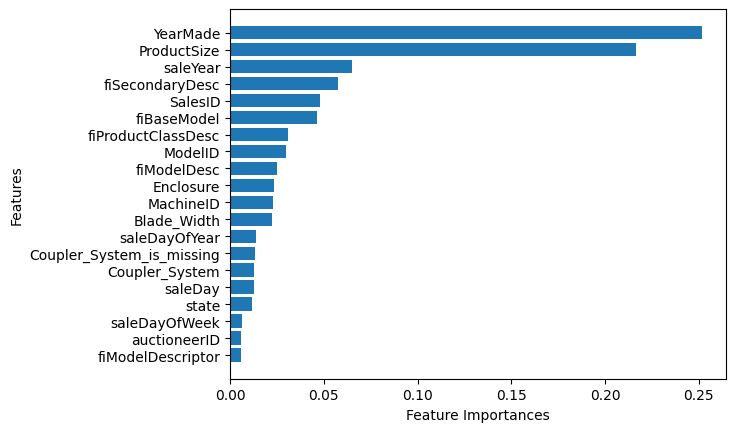

In [ ]:
plot_features(columns_order, feature_importances)

Based on the figure above, the most important features that influence the selling price are the made year and the size of the car.